# Notebook Purpose

This Jupyter notebook is designed to serve as an example of my coding abilities and habits.  I perform some brief analysis on sports data that I am personally interested in.

# Background Information

## A Brief Introduction to Formula 1
Formula 1 is the top racing category in motorsport, and sees 20 of the best drivers competing at upwards of 20 unique circuits per year.  Formula 1 is organized into 10 teams, each engineering their own cars, each with 2 drivers.  A race weekend contains practice, qualifying (whoever fastest lap starts the race in first place), and a race which typically lasts 1.5-2 hours (~300 kilometers).  Points are awarded to the top 10 race finishers per event, with the World Championship going to the driver with the most points at the end of the season.  Teams are also awarded the Driver's Championship if their pair of drivers net performance (representative of their team effort and engineering prowess) is the best over the season.


## Data Description

### Part 1 Synopsis

I use the [FastF1](https://github.com/theOehrly/Fast-F1) API to load lap telemetry data (speed v.s. time), which is resampled via the [f1_djsouthall/tools/fastf1_tools.py](https://github.com/djsouthall/f1_djsouthall/blob/main/tools/fastf1_tools.py) script.  I then create a Convolutional Neural Network (CNN) to classify the tracks from which each speed trace came from.

### Part 2 Synopsis

I perform statistical analysis of race meta-data which comes from pre-generated SQL tables ([f1_djsouthall/sql/make_tables.py](https://github.com/djsouthall/f1_djsouthall/blob/main/sql/make_tables.py)).

# Part 1 - Neural Networks for Classifying Tracks

## Purpose

Throughout a race the speed of an F1 car changes dramatically.  Maximized at the end of a straight before hard braking zones, with smooth acceleration out of each corner.  The speed v.s. time curve is the most iconic piece of telemetry used for interpreting a driver's lap quality.  Because each track has a distinct shape and unique combination of straights and corners, each telemetry trace tells a story of the circuit it belongs to; the signature of a track.

In this notebook I demonstrate the ability to identify the circuit in question solely based off of this speed telemetry trace using a *Supervised Neural Network* trained a subset of laps obtained from the F1 2022 season using the [fastf1](https://theoehrly.github.io/Fast-F1) package.

## Method

Telemetry traces are obtained for each track using the [fastf1](https://theoehrly.github.io/Fast-F1) package.  This tool does not provide data sampled at a regular rate, so some data cleaning is required for their use in this notebook.  This has been performed in advance using the functions provided by the [f1_djsouthall/tools/fastf1_tools.py](https://github.com/djsouthall/f1_djsouthall/blob/main/tools/fastf1_tools.py) script.  These laps are resampled to 0.1 second sampling, and all non-standard laps have been removed (i.e. laps with a safety car, yellow flags, pit stop in-lap, pit stop out-lap).  These standardized laps are loaded here and used for training the NN.

I am using the [tensorflow](https://www.tensorflow.org/) and [keras](https://keras.io/) APIs to construct and train this model.

In [1]:
# Perform imports and setup code

disable_gpu = False # Helpful for debugging, sometimes performs differently with GPU enabled. 

# OS imports
import os
import sys

# Common imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
%matplotlib widget
plt.ion()

# F1 imports
import fastf1
fastf1.Cache.enable_cache(os.environ['f1_cache'])  
sys.path.append(os.environ['f1_install'])
from tools.fastf1_tools import loadTelemForYear, loadTelemForEvent

# Reset plotting params from fastf1.
from IPython.utils import io
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100
plt.ion()

# ML imports and preparation
import tensorflow as tf

if disable_gpu:
    try:
        # Disable all GPUS
        tf.config.set_visible_devices([], 'GPU')
        visible_devices = tf.config.get_visible_devices()
        for device in visible_devices:
            assert device.device_type != 'GPU'
    except:
        # Invalid device or cannot modify virtual devices once initialized.
        pass
    tf.config.set_visible_devices([], 'GPU')
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from tensorflow import keras
import keras_tuner
from keras import optimizers

# Check for GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print('Number of GPUs Available: {}'.format(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Disable warnings
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

Number of GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Next we load in the lap telemetry and filter it down to the subset of drivers and tracks we wish to train on. 

In [2]:
# Load and filter lap telemetry.

# Specify lap telemetry info
path = os.path.join(os.environ['f1_install'], 'dataframes') # Location of pre-processed telemetry data.
year = 2022
telem_param = 'Speed'

# Get telem for entire year
refined_laps, track_index_key = loadTelemForYear(year, path=os.path.join(os.environ['f1_install'], 'dataframes'), telem_param=telem_param, return_index_key=True) # Formatted laps generated by ml/save_lap_telemetry.py

# Here we can filter to a subset of drivers
all_drivers = np.unique([c.split('_')[0] for c in refined_laps.columns])

# For simplicity here we only consider the laps of Max Verstappen, 
# however in principle we could train the NN to distinguish using all 
# driver data.
if True:
    choose_drivers = ['VER']
else:
    choose_drivers = all_drivers

# Here we have the option to only include a subset of the tracks.
# We will use all of them.
all_track_indices = list(track_index_key.keys())

if True:
    included_track_indices = all_track_indices # Use all of the tracks
else:
    included_track_indices = all_track_indices[:5] # Use only the first 5 tracks

columns = refined_laps.columns[[np.isin(c.split('_')[0], choose_drivers) for c in refined_laps.columns]] # Select subset of columns relevant to selected drivers
columns = columns[[np.isin(int(c.split('_')[1]), included_track_indices) for c in columns]] # Select subset of columns relevant to selected tracks
refined_laps = refined_laps[columns] # Reduce to only relevant columns (laps)

Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Bahrain_Grand_Prix_2022.pkl
Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Saudi_Arabian_Grand_Prix_2022.pkl
Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Australian_Grand_Prix_2022.pkl
Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Emilia_Romagna_Grand_Prix_2022.pkl
Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Miami_Grand_Prix_2022.pkl
Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Spanish_Grand_Prix_2022.pkl
Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Monaco_Grand_Prix_2022.pkl
Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Azerbaijan_Grand_Prix_2022.pkl
Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_Canadian_Grand_Prix_2022.pkl
Loading C:\Users\dsouthall\projects\f1\f1_djsouthall\dataframes\Speed_British_Grand_Prix_2022.pkl
Loa

Here we randomize the lap order.  Though keras shuffles these as well, I choose to do so in advance here for clarity.

At this stage I also clip the laps to the shortest lap of the year to remove NaN values where lap lengths differ.

In [3]:
randomized_indices = np.random.choice(range(len(refined_laps.columns)), len(refined_laps.columns))
refined_laps = refined_laps.iloc[:, randomized_indices]# Shuffled randomly
refined_laps = refined_laps.dropna() # Will cut off laps beyond shortest lap of the season.  Quick and dirty way to normalize data. 

print('Column label format: {DRIVER}_{EVENT_ID}_{LAP_ID}')
print(refined_laps.head().T.head(4).T) #Print the head of the first 4 laps

Column label format: {DRIVER}_{EVENT_ID}_{LAP_ID}
                         VER_22_65   VER_13_42   VER_18_48    VER_9_16
0 days 00:00:00         312.500000  293.500000  258.000000  316.000000
0 days 00:00:00.100000  312.875000  293.875000  259.125000  315.812500
0 days 00:00:00.200000  312.961538  293.961538  260.250000  315.596154
0 days 00:00:00.300000  312.987500  295.112500  261.431250  314.687500
0 days 00:00:00.400000  312.995868  296.599174  264.489669  313.557851


At this point we have obtained a set of consistently formatted (sampled equally in time and of equal length) speed traces.

## Sort Data
Here we split the data into training and testing data.  We then process the labels with a vectorizer and prepare the datasets as tensors.


In [4]:
# Get numpy array where each row is lap, and obtain labels. 
np_laps = refined_laps.to_numpy().T #Will cut off laps longer than shortest lap in the calender.
print(np_laps.shape)

labels = np.asarray([track_index_key[int(c.split('_')[1])]['name'] for c in refined_laps.columns])

training_percent = 0.8

training_n = int(training_percent*len(refined_laps.columns))
training_indices = np.random.choice(range(len(refined_laps.columns)), size=training_n, replace=False)

testing_indices = np.arange(len(refined_laps.columns))[~np.isin(np.arange(len(refined_laps.columns)), training_indices)]

print('Training on {} laps, and testing on {}'.format(len(training_indices), len(testing_indices)))


(1007, 680)
Training on 805 laps, and testing on 202


In [5]:
# Prepare preprocessing
scaler = keras.layers.Rescaling(scale=1.0/np.nanmax(np_laps))
vectorizer = keras.layers.TextVectorization(output_mode="int")
vectorizer.adapt(np.unique(labels))
num_classes = len(np.unique(labels))

# Prepare Training Data
training_labels = vectorizer(labels[training_indices]) - 2 # [2:] strips off the '' and 'UNK' default 0 and 1 values from vectorizer. - 2 accounts for shifting these such that labels start at 0.
training_data = scaler(np_laps[training_indices])

# Preparing Testing Data
testing_labels = vectorizer(labels[testing_indices]) - 2 # [2:] strips off the '' and 'UNK' default 0 and 1 values from vectorizer. - 2 accounts for shifting these such that labels start at 0.
testing_data = scaler(np_laps[testing_indices])

# For later human comprehension it is helpful to have a list of
# formatted GP names for each vectorized label number.  
formatted_name_dict = dict([(item['name'].replace('_','') , item['EventName'].replace('_','')) for key, item in track_index_key.items()])
label_dict = dict([(vectorizer(l).numpy()[0] - 2, formatted_name_dict[l]) for l in vectorizer.get_vocabulary()[2:]]) # [2:] strips off the '' and 'UNK' default 0 and 1 values from vectorizer. - 2 accounts for shifting these such that labels start at 0.

# These events are NOT necessarily in the same order as they are in the
# season or as they are loaded in and defined in track_index_key.
print(label_dict)

{0: 'United States Grand Prix', 1: 'São Paulo Grand Prix', 2: 'Spanish Grand Prix', 3: 'Singapore Grand Prix', 4: 'Saudi Arabian Grand Prix', 5: 'Monaco Grand Prix', 6: 'Miami Grand Prix', 7: 'Mexico City Grand Prix', 8: 'Japanese Grand Prix', 9: 'Italian Grand Prix', 10: 'Hungarian Grand Prix', 11: 'French Grand Prix', 12: 'Emilia Romagna Grand Prix', 13: 'Dutch Grand Prix', 14: 'Canadian Grand Prix', 15: 'British Grand Prix', 16: 'Belgian Grand Prix', 17: 'Bahrain Grand Prix', 18: 'Azerbaijan Grand Prix', 19: 'Austrian Grand Prix', 20: 'Australian Grand Prix', 21: 'Abu Dhabi Grand Prix'}


## Preparing Model
Now we start preparing the model.  Here I use a relatively simple sequentual model filled with dense layers. 

In [6]:
convolutional = True

print("training_data.shape[1] = ", training_data.shape[1])

if convolutional == False:
    model = keras.models.Sequential([
        keras.layers.Dense(units=50, activation='tanh', input_shape=(training_data.shape[1],)),
        keras.layers.Dense(units=32, activation='tanh'),
        keras.layers.Dense(units=16, activation='tanh'),
        keras.layers.Dense(units=len(label_dict), activation='softmax')
        ])
else:
    # A helpful reference that performs a similar analysis can be found at https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/
    model = keras.models.Sequential()
    model.add(keras.layers.Conv1D(filters=64, kernel_size=10, padding="same", activation='relu', input_shape=(training_data.shape[1],1) )) #Time series data, 1 feature (speed)
    model.add(keras.layers.Conv1D(filters=32, kernel_size=20, padding="same", activation='relu')) 
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.MaxPooling1D(pool_size=2))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(units=len(label_dict), activation='softmax'))

# optimizer = optimizers.Adam(clipvalue=0.5)
optimizer = keras.optimizers.Adam(learning_rate=1e-5)#RMSprop
model.summary()

# Using accuracy as the metric below seems important. I originally was using categorical accuracy and it was causing
# problems that I could not quite understand.  Accuracy works well though. 
model.compile(optimizer=optimizer,loss="sparse_categorical_crossentropy",metrics=['accuracy']) 

training_data.shape[1] =  680
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 680, 64)           704       
                                                                 
 conv1d_1 (Conv1D)           (None, 680, 32)           40992     
                                                                 
 dropout (Dropout)           (None, 680, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 340, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 10880)             0         
                                                                 
 dense (Dense)               (None, 22)                239382    
                          

## Training Model

In [7]:
# Perform checks on data
assert np.any(np.isnan(training_data)) == False
assert np.any(np.isnan(training_labels)) == False
assert np.any(np.isnan(testing_data)) == False
assert np.any(np.isnan(testing_labels)) == False
assert type(training_data) == type(training_labels)

print("training_data.shape", training_data.shape)

print('Training on {} laps, and testing on {}, attempting to distinguish between {} tracks.'.format(training_data.shape[0], testing_data.shape[0], len(np.unique(training_labels))))

if convolutional:
    epochs = 50
else:
    epochs = 1000
    
model.fit(training_data, training_labels, batch_size=20, epochs=epochs, verbose=1)#, validation_split=0.2

training_data.shape (805, 680)
Training on 805 laps, and testing on 202, attempting to distinguish between 22 tracks.
Epoch 1/50
41/41 [==============================] - 2s 6ms/step - loss: 3.0854 - accuracy: 0.0360
Epoch 2/50
41/41 [==============================] - 0s 4ms/step - loss: 3.0420 - accuracy: 0.0783
Epoch 3/50
41/41 [==============================] - 0s 4ms/step - loss: 2.9951 - accuracy: 0.1565
Epoch 4/50
41/41 [==============================] - 0s 4ms/step - loss: 2.9426 - accuracy: 0.1851
Epoch 5/50
41/41 [==============================] - 0s 5ms/step - loss: 2.8724 - accuracy: 0.2472
Epoch 6/50
41/41 [==============================] - 0s 4ms/step - loss: 2.7898 - accuracy: 0.2969
Epoch 7/50
41/41 [==============================] - 0s 4ms/step - loss: 2.6824 - accuracy: 0.3578
Epoch 8/50
41/41 [==============================] - 0s 4ms/step - loss: 2.5556 - accuracy: 0.4795
Epoch 9/50
41/41 [==============================] - 0s 4ms/step - loss: 2.3703 - accuracy: 0.5590


## Validating Model

In [8]:
result = model.evaluate(testing_data,testing_labels,verbose=1)

# Changing the accuracy into a percentage
testing_acc = result[1]*100
# Printing the accuracy
print('Test Accuracy - ', testing_acc,'%')
print(dict(zip(model.metrics_names, result)))

predictions = model(testing_data, training=False)
print('Looping through the testing data and checking results:')
for i, (expect, predict) in enumerate(zip(testing_labels.numpy() , predictions.numpy())):
    print('{:5}/{:<5}: True: {:25} Predicted: {:25} | {:^7} | Choice probability = {:.1f}%'.format(i+1, testing_data.shape[0], label_dict[expect[0]], label_dict[predict.argmax()], ['Wrong', 'Correct'][predict.argmax() == expect[0]],  predict.max()*100))

7/7 [==============================] - 0s 5ms/step - loss: 0.1023 - accuracy: 0.9901
Test Accuracy -  99.00990128517151 %
{'loss': 0.102315254509449, 'accuracy': 0.9900990128517151}
Looping through the testing data and checking results:
    1/202  : True: Azerbaijan Grand Prix     Predicted: Azerbaijan Grand Prix     | Correct | Choice probability = 92.2%
    2/202  : True: Dutch Grand Prix          Predicted: Dutch Grand Prix          | Correct | Choice probability = 90.0%
    3/202  : True: Miami Grand Prix          Predicted: Miami Grand Prix          | Correct | Choice probability = 97.6%
    4/202  : True: São Paulo Grand Prix      Predicted: São Paulo Grand Prix      | Correct | Choice probability = 94.1%
    5/202  : True: Bahrain Grand Prix        Predicted: Bahrain Grand Prix        | Correct | Choice probability = 95.0%
    6/202  : True: United States Grand Prix  Predicted: United States Grand Prix  | Correct | Choice probability = 95.7%
    7/202  : True: Dutch Grand Prix  

## Part 1 Conclusions

Using machine learning with *keras* and *tensorflow* we have been able to create a model capable of distinguishing tracks based solely upon the speed trace of Formula 1 drivers! 

Below I plot a a summary of the validation laps.  Each lap is plotted next to the corresponding circuit.  If a lap was incorrectly identified its telemetry trace will be red, otherwise it will be black.  As 100% accuracy has been achieved, this is not particularly relevant, however one could choose a lower number of epochs should they choose.

The circuit layouts are also plotted. As each lap was clipped to the same lap time to quickly eliminate NaN values where lap times are jagged, most circuits were only partially fit to (the front % that results in the same laptime as the shortest time in the training data).  To indicate the portion of track that was included (corresponding to the shown partial telemetry traces on the right) I have plotted a blue line within the circuit map for the included segment.

### Future Work

This project has been a fun example of what can be done with machine learning and this dataset, however things could always be improved.  Should work continue on this project, future work could account for: handling full laps, handling non-standard laps (rain, yellow flag, etc.), training on randomly rolled traces rather than traces that start at the same point in the lap, handling segments of laps, etc.

Plotting testing data and track circuits.  Any trace that was incorrectly identified has will be colored red, otherwise it will be black.


core           INFO 	Loading data for United States Grand Prix - Qualifying [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached data for timing_data
api            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
api            INFO 	Using cached data for session_status_data
api            INFO 	Using cached data for track_status_data
api            INFO 	Using cached data for car_data
api            INFO 	Using cached data for position_data
api            INFO 	Using cached data for weather_data
api            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['55', '16', '1', '11', '44', '63', '18', '4', '14', '77', '23', '5', '10', '24', '22', '20', '3', '31', '47', '6']
core           INFO 	Loading data for São Paulo Grand Prix - Qualifying [v2.3.0]
api            INFO 	Using cached data for driver_info
api            INFO 	Using cached 

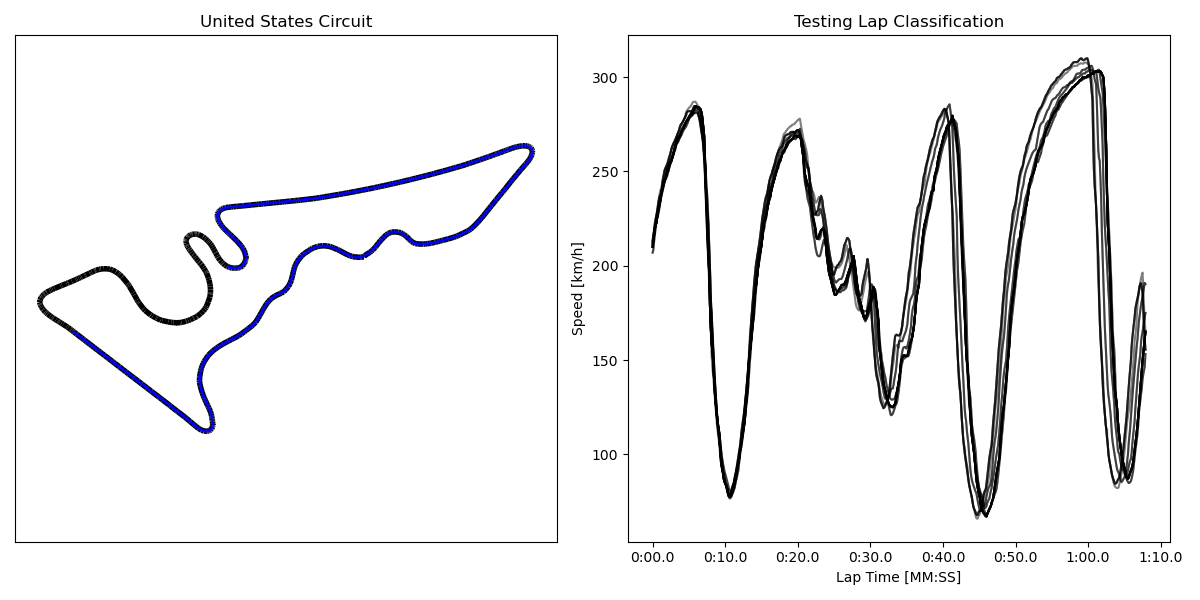

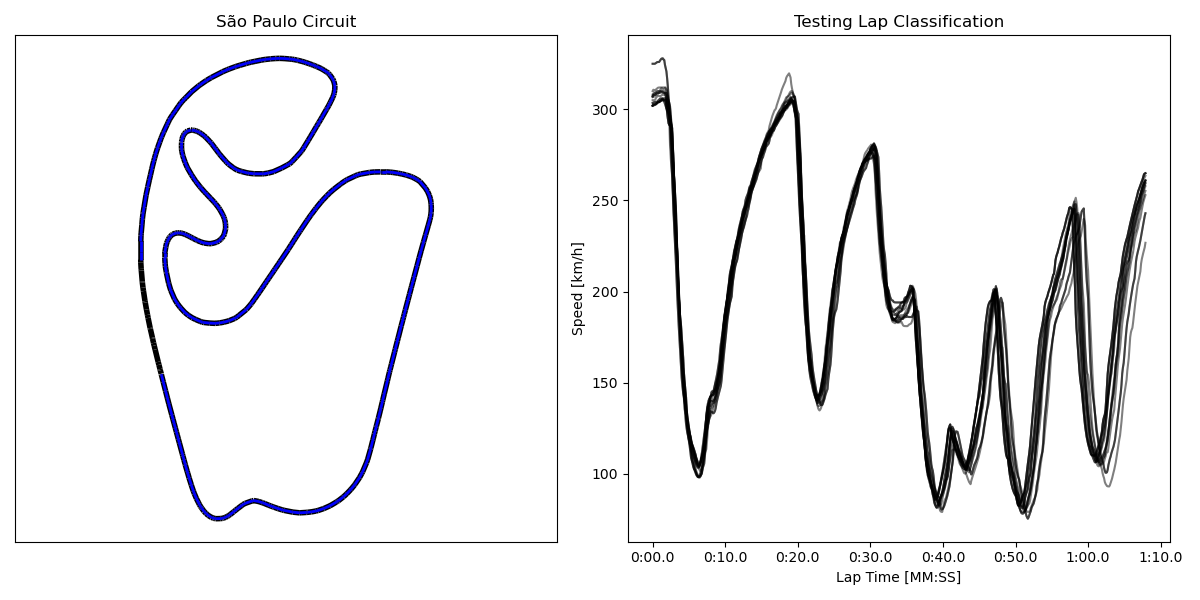

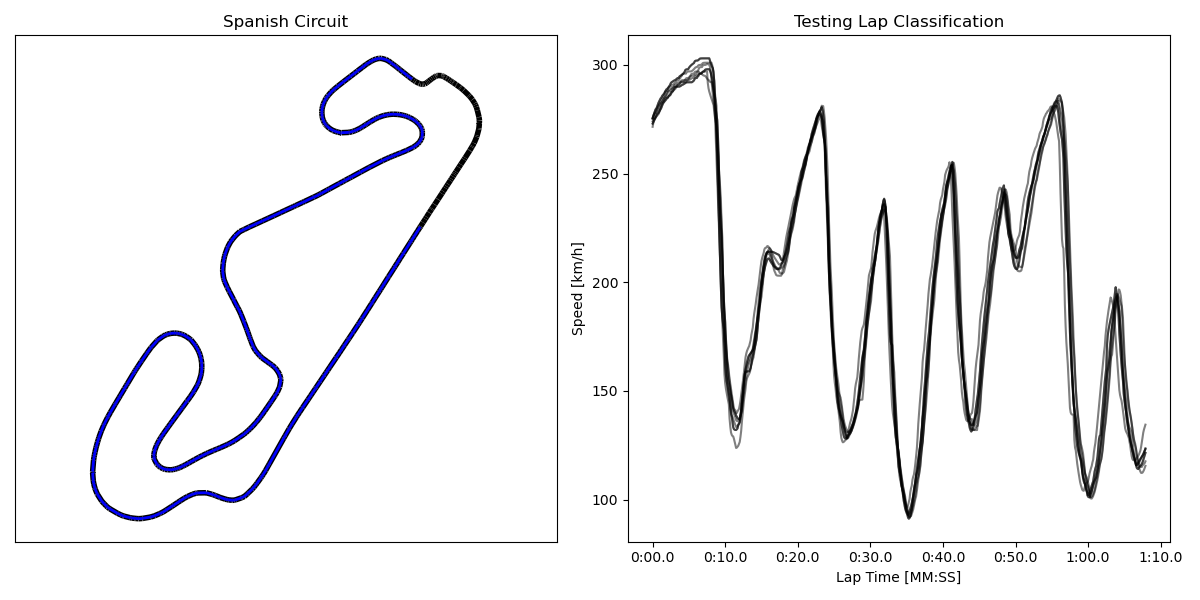

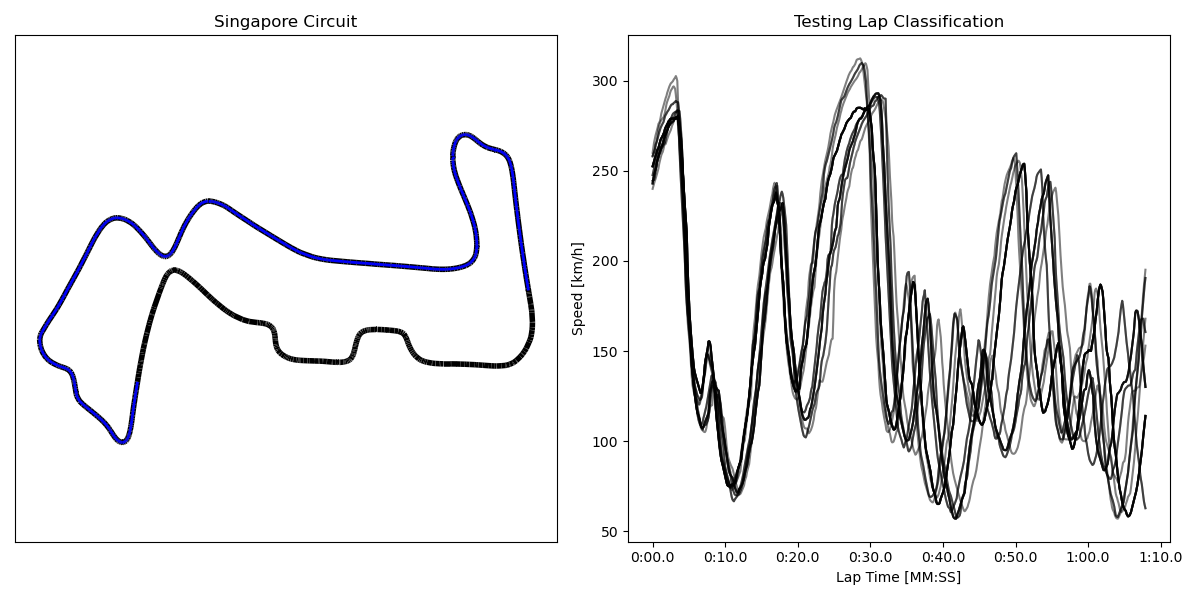

In [9]:
print('Plotting testing data and track circuits.  Any trace that was incorrectly identified has will be colored red, otherwise it will be black.')
plt.ion() #Note if not displaying as widgets in a vscode jupyter notebook add the line to the display settings: "notebook.displayOrder": ["application/vnd.jupyter.widget-view+json","image/png", "text/plain"]
for i, (event_index , event_name) in enumerate(label_dict.items()):
    if i > 3:
        break # Limiting plotted examples for conciseness
    fig = plt.figure(num=event_name) # Sets jupyter figure title
    ax1 = plt.subplot(1, 2, 1) # For sharex
    ax1.title.set_text(event_name.replace('Grand Prix','Circuit'))
    ax2 = plt.subplot(1, 2, 2) # For sharex
    ax2.title.set_text('Testing Lap Classification')
    
    # Load session info and fastest qualifying lap for outline
    session = fastf1.get_session(2022, event_name, 'Q')
    session.load()
    lap = session.laps.pick_fastest()
    tel = lap.get_telemetry()

    # Plot the map layout.
    plt.sca(ax1)

    # Plot full map layout
    x = np.array(tel['X'].values)
    y = np.array(tel['Y'].values)
    times = np.array(tel['Time'])

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc_comp = LineCollection(segments, color='k')
    lc_comp.set_linewidth(4)
    ax1.add_collection(lc_comp)

    # Plot points actually in telemetry trace.
    points2 = np.array([x[times < refined_laps.index.max()], y[times < refined_laps.index.max()]]).T.reshape(-1, 1, 2)
    segments2 = np.concatenate([points2[:-1], points2[1:]], axis=1)

    lc_comp2 = LineCollection(segments2, color='b')
    lc_comp2.set_linewidth(2)
    ax1.add_collection(lc_comp2)

    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)

    plt.sca(ax2)
    ax2.title.set_text('Testing Lap Classification')
    plt.xlabel('Lap Time [MM:SS]')
    plt.ylabel('Speed [km/h]')

    for i, (expect, predict) in enumerate(zip(testing_labels.numpy() , predictions.numpy())):
        if expect != event_index:
            continue
        else:
            lap = refined_laps[refined_laps.columns[testing_indices[i]]]
            plt.plot(lap, c=['r','k'][predict.argmax() == expect[0]], alpha=[1.0,0.5][predict.argmax() == expect[0]])
    plt.tight_layout()


# Part 2 - Season Summary

## Purpose

Above I showed some work differentiating tracks using a CNN on speed telemetry data.  Here I just wanted to demonstrate querying the meta data tables I generated using [f1_djsouthall/sql/make_tables.py](https://github.com/djsouthall/f1_djsouthall/tree/main/sql/make_tables.py).  Please see that script to get an example of my approach to developing tools. 


## SQL Summary
A quick summary of the season using SQL. 

In [10]:
import psycopg2 as pg2
import pandas as pd
import pandas.io.sql as psql
from tabulate import tabulate

sql_user = 'postgres'
sql_password = 'password' # Security!
db_name = 'formula1_2022'

connection = pg2.connect(database=db_name, host='localhost', port='5432', user=sql_user,password=sql_password) # Connection for SQL calls

print("Let's explore the 2022 Formula 1 Season!\n")

'''
SELECT driver_code AS driver, SUM(race_points) AS championship_points FROM results 
    GROUP BY driver_code 
    ORDER BY SUM(race_points) DESC
    LIMIT 10;
'''
championship_standings_df = psql.read_sql('SELECT driver_code AS driver, SUM(race_points) AS championship_points FROM results GROUP BY driver_code ORDER BY SUM(race_points) DESC LIMIT 10;', connection)

drivers_df = psql.read_sql('SELECT * FROM drivers;', connection)

champ_df = drivers_df.query('driver_code == "{}"'.format(championship_standings_df['driver'][0]))

print('The 2022 world champion was {} {} with a total of {} points.'.format(champ_df['first_name'].squeeze(),champ_df['last_name'].squeeze(), championship_standings_df['championship_points'].squeeze()[0]))
print('The top 10 standings are as follows:')
print(tabulate(championship_standings_df, headers='keys', tablefmt='psql'))
print('\n')


# Determine champions best weekend, get information.
'''
SELECT results.event_id, results.driver_code, SUM(results.race_points) AS weekend_points, events.* FROM results
    INNER JOIN events ON results.event_id = events.event_id
    WHERE results.driver_code LIKE %(driver_code)s
    GROUP BY results.event_id, events.event_id, results.driver_code
    ORDER BY SUM(results.race_points) DESC
    LIMIT 1;
'''
best_weekend_simple = psql.read_sql('SELECT results.event_id, results.driver_code, SUM(results.race_points) AS weekend_points, events.* FROM results INNER JOIN events ON results.event_id = events.event_id WHERE results.driver_code LIKE %(driver_code)s GROUP BY results.event_id, events.event_id, results.driver_code ORDER BY SUM(results.race_points) DESC LIMIT 1;', connection, params={'driver_code':championship_standings_df['driver'][0]})
print('{}\'s best weekend was at {}, where he obtained {} points.\nThis was a {} weekend and the GP was held on {} as the "{}"'.format(champ_df['first_name'].squeeze(), best_weekend_simple['location'][0], best_weekend_simple['weekend_points'][0], best_weekend_simple['event_format'][0], best_weekend_simple['race_date'][0], best_weekend_simple['event_name'][0]))

connection.close()

Let's explore the 2022 Formula 1 Season!

The 2022 world champion was Max Verstappen with a total of 454 points.
The top 10 standings are as follows:
+----+----------+-----------------------+
|    | driver   |   championship_points |
|----+----------+-----------------------|
|  0 | VER      |                   454 |
|  1 | LEC      |                   308 |
|  2 | PER      |                   305 |
|  3 | RUS      |                   275 |
|  4 | SAI      |                   246 |
|  5 | HAM      |                   240 |
|  6 | NOR      |                   122 |
|  7 | OCO      |                    92 |
|  8 | ALO      |                    81 |
|  9 | BOT      |                    49 |
+----+----------+-----------------------+


Max's best weekend was at Imola, where he obtained 34 points.
This was a sprint weekend and the GP was held on 2022-04-24 as the "FORMULA 1 ROLEX GRAN PREMIO DEL MADE IN ITALY E DELL'EMILIA-ROMAGNA 2022"


## Part 2 Conclusion
In this section very few lines of code are used to make a query which summarizes the final standings of the Formula 1 season.  This works because it connects to a pre-generated data base (made using [f1_djsouthall/sql/make_tables.py](https://github.com/djsouthall/f1_djsouthall/tree/main/sql/make_tables.py)).